<a href="https://colab.research.google.com/github/YoonyoungChoi/problem_set/blob/main/STA503_5_%EC%B5%9C%EC%9C%A4%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install arch
!pip install statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import arch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import io
from scipy.stats import norm, t
from statsmodels.formula.api import ols

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 43.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Problem 1** A coding exercise for the small sample properties of OLS.\
1) Generate 100 independent samples, each containing 100 observations, for a variable $y_t$ distributed as $y_t \mid y_{t-1} \sim N(y_{t-1},1)$ where 1. you might want to fix the seed of your random number generator, 2. do NOT fix $y_0$ to the same value in all the samples, otherwise the samples will not be independent, 3. unconditional expectation is not defined, thus $y_0$ can be any real number\
The procedure will be, generate $y_0$ from a very large domain of uniform distribution, then set that value as the mean value, and run normal simulation to find $y_1$, and do the same for $y_2, y_3$, and etc.\
2) In each of the 100 samples run the OLS estimation, $(X^{'}X)^{-1}X^{'}Y$, of the model\
$y_t = \alpha + \rho y_{t-1} + \epsilon_t$
and compute the t-test of the null hypothesis $\alpha = 0$ at the 5 \% confidence level. Use loop functions.\
3) In how many samples is the hypothesis rejected? Is this surprising?


In [3]:
# Random sampling (seed:1)
np.random.seed(1)
y_0=np.random.uniform(-10000,10000,100)
sample={}
for i in range(100):
  temp=[]
  temp.append(y_0[i])
  for j in range(99):
    temp.append(np.random.normal(temp[-1],1,1)[0])
  sample[i]=temp

In [4]:
# Fit OLS
import scipy
critical_value=scipy.stats.t.ppf(0.975, df=97)
count=0
for i in range(100):
  y=sample[i]
  y_t=np.array(y[1:]) #Exclude y0
  y_t1=np.array(y[:-1]) #Exclude y99

  df=pd.DataFrame({'y_t': y_t, 'y_t1': y_t1})
  res=ols('y_t ~y_t1',data=df).fit()

  # Hypothesis test for alpha ==> H_0: alpha=0, H_1: not H_0
  t=(res.params[0]-0)/res.bse[0] #follows t(97)=standard normal
  if t > critical_value:
    count +=1
print(count)

14


In [5]:
# Among 100 samples, 10~15 samples turned out to be reject null hypothesis test for alpha
# Why? ==> y_t is generated by y_{t-1} and error term without this information follows normal distribution N(0,1)
# Alpha was not significant when considering DGP
# Nevertheless, alpha must be considered

**Problem 2** Suppose you have the data\
$x_1=1; x_2 =2; x_3=3/2$, $y_1=2; y_2=1; y_3=-8/3$ and two possible models.\
Model 0 given by\
$y_i=\theta x_i + \epsilon_i \sim i.i.d.N(0,1/2), \theta \in \mathbb{R}$\
Model 1 given by\
$y_i= \phi x_i^2 + \eta_i \sim i.i.d.N(0,1/2), \phi \in \mathbb{R}$\
where in both models errors and regressors are independent.\
1) Define the variable $m$ that takes value 0 if model 0 is true and value 1 if model 1 is true. Write down the likelihood $L(\left\{ y_i,x_i \right\}_{i=1}^3 \mid \theta, \phi, m) = L(data \mid \theta, \phi, m)$\
2) Suppose you have the flat (improper) prior $p(\theta) = p(\phi) =1$. Find the posteriors for both $p(\theta \mid data, m=0)$. Plot the posterior distributions in one graph.\
3) Suppose you assign prior probability 0.5 to each of the models. Which model is more likely to be the data generating process (DGP) of the observed data?\
4) Find (and plot) the posteriors $p(\theta \mid data)$ and $p(\phi \mid data)$ - Both will be a linear combination of the posterior of each parameter.

1) Define the variable  m  that takes value 0 if model 0 is true and value 1 if model 1 is true. Write down the likelihood $L({yi,xi}3i=1∣θ,ϕ,m)=L(data∣θ,ϕ,m)$

In [6]:
# 1)Define the varialbe m: value 0 if model 0 is true, value 1 elsewhere
# Assumption of A1~A5N

y=[2,1,-3/8]
x=[1,2,3/2]
x2=np.array(x) ** 2

df=pd.DataFrame({'y':y, 'x':x, 'x2':x2})
res1=ols('y~x', data=df).fit()
res2=ols('y~x2', data=df).fit()

# Obtain residual
resid1=res1.resid
resid2=res2.resid

# Calculating likelihood function (LF)
def likelihood1(theta):
  likelihood=np.power((np.sqrt(np.pi)),-3/2)*np.exp(-((29/4*theta**2)+109/9))
  return likelihood

def likelihood2(theta):
  likelihood=np.power((np.sqrt(np.pi)),-3/2)*np.exp(-((353/16*theta**2)+109/9))
  return likelihood

2) Suppose you have the flat (improper) prior  p(θ)=p(ϕ)=1 . Find the posteriors for both  p(θ∣data,m=0) . Plot the posterior distributions in one graph.

In [7]:
# Flat prior==> no information; 'Let the data speak for themselves' - distribution described by information
# Laplace prior: prior=1
# Jeffrey's prior: proor= I^(0.5) I is Fisher Information Matrix=(variance)^(-1)
# If the data follows normal distribution Jeffrey's posterior: I^(1)=1/(sigma^2)=1/0.5=2 (in this question)

# Posterior = likelihood * prior (evidence was omitted because of complex calculation)
output1=[likelihood1(i) for i in np.linspace(-2,2,10000)]
output2=[likelihood2(i) for i in np.linspace(-2,2,10000)]

# How to calculate posterior without calculation of evidence(marginal pdf)
# ==> Scaling sum of output to be 1 (because posterior is propotional to prior*likelihood)
posterior1=output1/np.sum(output1)
posterior2=output2/np.sum(output2)
print(np.sum(posterior2))

0.9999999999999999


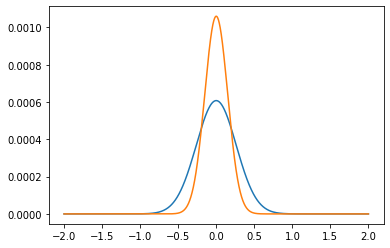

In [8]:
#posterior
plt.plot(np.linspace(-2,2,10000), posterior1, label='ols')
plt.plot(np.linspace(-2,2,10000), posterior2, label='polynomial')

3) Suppose you assign prior probability 0.5 to each of the models. Which model is more likely to be the data generating process (DGP) of the observed data?

In [9]:
# Bayes Factor
# Evidence (Marginal pdf) = sum of output (if intergral interval divided more frequently then the sum will be more close to output)
# Odds=p/1-1 (the odds of each model set to be same) 
BF=(np.sum(output1)/np.sum(output2))*(1/1)
print(BF)

1.744449325224354


In [11]:
# Intuition: Bayes Facor give to be proportion of marginal pdf (evidence) of H_0, H_1
# If odds of two models is same to be 1 (odds=1), it will be Likelihood Ratio Test
# Therefore, hypothesis test for Bayes Factor is extended version of likelihood ratio test

# 1<=BF <=3 : Weak
# 3< BF <=12 : Positive
# 12<BF<=150 : Strong
# BF>150 : Decisive

# The value are subjective (like p-value= 0.1, 0.05, 0.01)
# Why compare the odds? We don't have information of poptulation, we only have sample data.


In [10]:
# How can we use this result? ===> we interprete the data by ratio of odds 
# p= odds/ (odds+1)

model0_prob=BF/(BF+1)
model1_prob=1-model0_prob
print(model0_prob)
print(model1_prob)

# (1) Choose model_0/ (2) Overweigh 64% on model_0 and 36% on model_1
# As data updataed, model_0 will be overweighted
# Why? OLS is best when Gauss-Markov assumption A1~A5N accomplished

0.635628178371174
0.364371821628826


4) Find (and plot) the posteriors  $p(θ∣data)$  and  $p(ϕ∣data)$ - Both will be a linear combination of the posterior of each parameter.

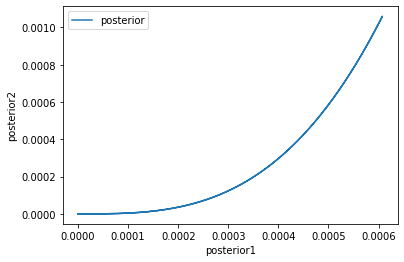

In [13]:
#4
#Posterior
plt.plot(posterior1, posterior2, label='posterior')
plt.xlabel('posterior1')
plt.ylabel('posterior2')
plt.legend()